Importare le librerie


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from PIL import Image
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split


# Verifica GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

Device utilizzato: cpu


Caricare i dati

In [ ]:
# Monta Google Drive
drive.mount('/content/drive')
train_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/train'
test_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test'

# Data augmentation avanzata per il training set
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=15, scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Trasformazioni base per il test set
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Caricamento dei dataset
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Verifica classi
class_names = train_data.classes
print(f"Classi trovate: {class_names}")

# Funzione per creare il loader di validazione (split casuale)
def get_train_val_loaders(train_data, val_ratio=0.2, batch_size=32):
    # Calcola la dimensione del set di validazione
    val_size = int(len(train_data) * val_ratio)
    train_size = len(train_data) - val_size
    # Suddivide casualmente il dataset
    train_subset, val_subset = random_split(train_data, [train_size, val_size])

    # Crea i DataLoader per il training e la validazione
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classi trovate: ['control', 'retinite']


# Definizione della CNN

In [ ]:
# Modello SimpleCNN con miglioramenti
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 37 * 37, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Inizializzazione del modello
model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=87616, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


# Funzione di perdita e ottimizzazione

In [ ]:
# Funzione di perdita e ottimizzatore avanzato
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


# Addestrare il modello

In [ ]:
# Funzione di addestramento e validazione
def train_model(model, train_data, criterion, optimizer, scheduler, epochs=10, val_ratio=0.2):
    for epoch in range(epochs):
        # Creazione del train_loader e val_loader per questa epoca
        train_loader, val_loader = get_train_val_loaders(train_data, val_ratio)

        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            # Azzeramento dei gradienti
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = 100 * train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = 100 * val_correct / val_total

        # Stampa dei risultati
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss:   {val_loss/len(val_loader):.4f}, Val Accuracy:   {val_accuracy:.2f}%")
        scheduler.step(val_loss / len(val_loader))

# Avvio dell'addestramento
train_model(model, train_data, criterion, optimizer, scheduler, epochs=15, val_ratio=0.2)

Epoch 1/15
  Train Loss: 11.4592, Train Accuracy: 79.59%
  Val Loss:   7.2890, Val Accuracy:   84.54%
Epoch 2/15
  Train Loss: 13.9828, Train Accuracy: 79.59%
  Val Loss:   13.0081, Val Accuracy:   81.64%
Epoch 3/15
  Train Loss: 12.5418, Train Accuracy: 82.97%
  Val Loss:   13.8701, Val Accuracy:   79.71%
Epoch 4/15
  Train Loss: 12.7808, Train Accuracy: 81.40%
  Val Loss:   11.4292, Val Accuracy:   85.02%
Epoch 5/15
  Train Loss: 11.2463, Train Accuracy: 82.97%
  Val Loss:   12.0940, Val Accuracy:   83.57%
Epoch 6/15
  Train Loss: 11.0017, Train Accuracy: 80.43%
  Val Loss:   10.8418, Val Accuracy:   80.68%
Epoch 7/15
  Train Loss: 10.6117, Train Accuracy: 81.04%
  Val Loss:   5.5193, Val Accuracy:   81.64%
Epoch 8/15
  Train Loss: 7.7067, Train Accuracy: 81.88%
  Val Loss:   4.6757, Val Accuracy:   85.51%
Epoch 9/15
  Train Loss: 2.8398, Train Accuracy: 80.43%
  Val Loss:   0.3766, Val Accuracy:   86.96%
Epoch 10/15
  Train Loss: 2.2069, Train Accuracy: 81.16%
  Val Loss:   1.0793, 

# Valutazione del modello

In [ ]:
# Funzione per valutare il modello
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

# Valutazione del modello
evaluate(model, test_loader)


Accuracy: 82.95%


# Matrice di confusione

Confusion Matrix:
[[208   1]
 [ 43   6]]


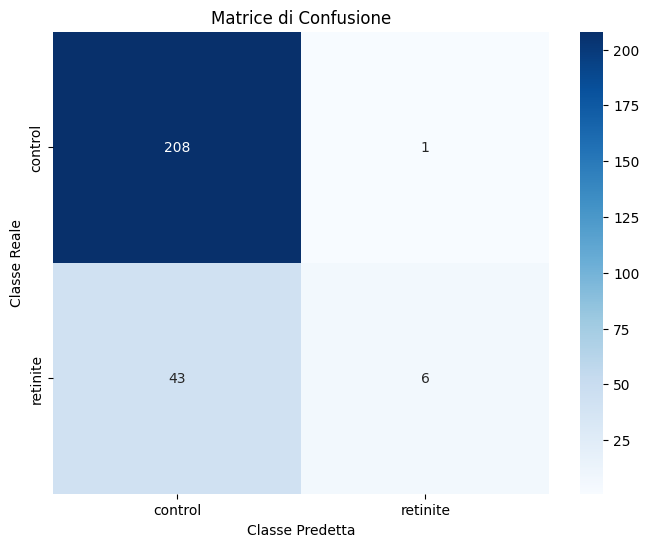

Classification Report:
              precision    recall  f1-score   support

     control       0.83      1.00      0.90       209
    retinite       0.86      0.12      0.21        49

    accuracy                           0.83       258
   macro avg       0.84      0.56      0.56       258
weighted avg       0.83      0.83      0.77       258



In [ ]:
# Funzione per matrice di confusione
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.xlabel('Classe Predetta')
    plt.ylabel('Classe Reale')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Matrice di confusione
plot_confusion_matrix(model, test_loader, class_names)

Utilizzare il modello

In [ ]:
# Funzione per fare una previsione su una singola immagine
def predict(model, image_path):
    model.eval()

    transform = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        prediction = (output.squeeze() > 0.5).float()

    print(f"Predizione: {'Retinite Pigmentosa' if prediction == 1 else 'Controllo'}")

# Esegui una previsione su un'immagine
img_path = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test/retinite/Retinitis Pigmentosa73.jpg'
predict(model, img_path)

Predizione: Controllo
